## 1. Prepare data and voxelMorph code



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/final/RegistGans')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import voxelmorph2d as vm2d
import voxelmorph3d as vm3d

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.transform import resize
import multiprocessing as mp
from tqdm import tqdm
import gc
import time
from sklearn.model_selection import train_test_split
from matplotlib.lines import Line2D
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable

use_gpu = torch.cuda.is_available()

In [ ]:
## Basic dataloading for MNIST.
# Just to make sure it works for the rest of this notebook.

transform = transforms.Compose([
        # transforms.Resize(32),
        # transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5))
])

training = dataset.MNIST(root ='./data', transform = transform, train=True, download=True)
testing =  dataset.MNIST(root ='./data', transform = transform, train=False, download=True)
# traindata, valdata = data.Subset(training,range(0, 50000)), torch.utils.data.Subset(training, range(50000, 60000))
# train_loader = data.DataLoader(dataset=traindata, batch_size = 100, shuffle=True)
# test_loader = data.DataLoader(dataset=testing, batch_size = 100, shuffle=False)
# vali_loader = data.DataLoader(dataset=valdata, batch_size = 100, shuffle=False)
## 



torch.Size([1, 28, 28])


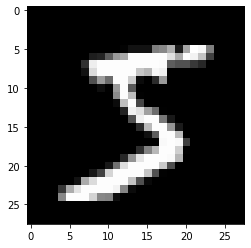

In [ ]:
print(training[0][0].shape)
plt.imshow(training[0][0].squeeze(),cmap='gray', interpolation='none')

## 2. Preparing GANs

In [ ]:
digit = 5
valIDX = 1000
idx = training.train_labels == digit
# print(training[0][0].shape)

x_digit = training.train_data[idx]
y_digit = training.train_labels[idx]
# print(x_digit[0].shape)

x_train = x_digit[:-valIDX, ...]
y_train = y_digit[:-valIDX]
x_val = x_digit[-valIDX:, ...]  # this indexing means "the last nb_val entries" of the zeroth axis
y_val = y_digit[-valIDX:]

pad_amount = ((0, 0), (2,2), (2,2))

# fix data
x_train = np.pad(x_train, pad_amount, 'constant')
x_val = np.pad(x_val, pad_amount, 'constant')
print(x_train[0].shape)

val_dataset = data.TensorDataset(torch.Tensor(x_val), y_val)


# print(x_train.shape[0])

torch.Size([1, 28, 28])
torch.Size([28, 28])
(32, 32)
4421


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
if x_train.shape[0] % 2 ==0:
  idx_moving, idx_fixed = train_test_split(range(x_train.shape[0]), test_size = .5)
else:
  idx_moving, idx_fixed = train_test_split(range(x_train.shape[0]-1), test_size = .5)
training_set = data.TensorDataset(torch.Tensor(x_train[idx_moving, :]).unsqueeze(3),
                                   torch.Tensor(x_train[idx_fixed, :]).unsqueeze(3))
training_generator = data.DataLoader(training_set, batch_size=2, shuffle=True)

if x_val.shape[0] % 2 ==0:
  idx_moving, idx_fixed = train_test_split(range(x_val.shape[0]), test_size = .5)
else:
  idx_moving, idx_fixed = train_test_split(range(x_val.shape[0]-1), test_size = .5)
validation_set = data.TensorDataset(torch.Tensor(x_val[idx_moving, :]).unsqueeze(3),
                                   torch.Tensor(x_val[idx_fixed, :]).unsqueeze(3))

validation_generator = data.DataLoader(validation_set, batch_size=64, shuffle=True)

In [ ]:
# for moving, fixed in validation_generator:
#   print(moving.shape)

In [ ]:
class VoxelMorph():
    """
    VoxelMorph Class is a higher level interface for both 2D and 3D
    Voxelmorph classes. It makes training easier and is scalable.
    """

    def __init__(self, input_dims, is_2d=False, use_gpu=False):
        self.dims = input_dims
        if is_2d:
            self.vm = vm2d
            self.voxelmorph = vm2d.VoxelMorph2d(input_dims[0] * 2, use_gpu)
        else:
            self.vm = vm3d
            self.voxelmorph = vm3d.VoxelMorph3d(input_dims[0] * 2, use_gpu)
        self.optimizer = optim.SGD(self.voxelmorph.parameters(), lr=1e-4, momentum=0.99)
        self.params = {'batch_size': 3,
                       'shuffle': True,
                       'num_workers': 6,
                       'worker_init_fn': np.random.seed(42)
                       }
        self.device = torch.device("cuda:0" if use_gpu else "cpu")

    def check_dims(self, x):
        try:
            if x.shape[1:] == self.dims:
                return
            else:
                raise TypeError
        except TypeError as e:
            print("Invalid Dimension Error. The supposed dimension is ",
                  self.dims, "But the dimension of the input is ", x.shape[1:])

    def forward(self, x):
        self.check_dims(x)
        return voxelmorph(x)

    def calculate_loss(self, y, ytrue, n=9, lamda=0.01, is_training=True):
        loss = self.vm.vox_morph_loss(y, ytrue, n, lamda)
        return loss

    def train_model(self, batch_moving, batch_fixed, n=9, lamda=0.01, return_metric_score=True):
        self.optimizer.zero_grad()
        batch_fixed, batch_moving = batch_fixed.to(self.device), batch_moving.to(self.device)
        registered_image, _ = self.voxelmorph(batch_moving, batch_fixed)
        print(batch_fixed.shape)
        train_loss = self.calculate_loss(registered_image, batch_fixed, n, lamda)
        train_loss.backward()
        self.optimizer.step()
        if return_metric_score:
            train_dice_score = self.vm.dice_score(registered_image, batch_fixed)
            return train_loss, train_dice_score
        return train_loss

    def get_test_loss(self, batch_moving, batch_fixed, n=9, lamda=0.01):
        with torch.set_grad_enabled(False):
            registered_image, _ = self.voxelmorph(batch_moving, batch_fixed)
            val_loss = self.vm.vox_morph_loss(registered_image, batch_fixed, n, lamda)
            val_dice_score = self.vm.dice_score(registered_image, batch_fixed)
            return val_loss, val_dice_score

In [ ]:
# def main():
#     '''
#     In this I'll take example of FIRE: Fundus Image Registration Dataset
#     to demostrate the working of the API.
#     '''
#     vm = VoxelMorph((1, 32, 32), is_2d=True)  # Object of the higher level class
#     # DATA_PATH = './fire-fundus-image-registration-dataset/'
#     params = {'batch_size': 1,
#               'shuffle': True,
#               'num_workers': 6,
#               'worker_init_fn': np.random.seed(42)
#               }

#     max_epochs = 2
#     # filename = list(set([x.split('_')[0]
#     #                      for x in os.listdir('./fire-fundus-image-registration-dataset/')]))
#     # partition = {}
#     # partition['train'], partition['validation'] = train_test_split(
#     #     filename, test_size=0.33, random_state=42)

#     # # Generators
#     # training_set = Dataset(partition['train'])
#     # training_generator = data.DataLoader(training_set, **params)

#     # validation_set = Dataset(partition['validation'])
#     # validation_generator = data.DataLoader(validation_set, **params)

#     # Loop over epochs
#     for epoch in range(max_epochs):
#         start_time = time.time()
#         train_loss = 0
#         train_dice_score = 0
#         val_loss = 0
#         val_dice_score = 0
#         for batch_moving, batch_fixed in training_generator:
#             loss, dice = vm.train_model(batch_moving, batch_fixed)
#             train_dice_score += dice.data
#             train_loss += loss.data
#         print('[', "{0:.2f}".format((time.time() - start_time) / 60), 'mins]', 'After', epoch + 1, 'epochs, the Average training loss is ', train_loss *
#               params['batch_size'] / len(training_set), 'and average DICE score is', train_dice_score.data * params['batch_size'] / len(training_set))
#         # Testing time
#         start_time = time.time()
#         for batch_moving, batch_fixed in validation_generator:
#             # print(batch_moving.shape)
#             # Transfer to GPU
#             loss, dice = vm.get_test_loss(batch_moving, batch_fixed)
#             val_dice_score += dice.data
#             val_loss += loss.data
#         print('[', "{0:.2f}".format((time.time() - start_time) / 60), 'mins]', 'After', epoch + 1, 'epochs, the Average validations loss is ', val_loss *
#               params['batch_size'] / len(validation_set), 'and average DICE score is', val_dice_score.data * params['batch_size'] / len(validation_set))

# if __name__ == "__main__":
#     main()
    

## 3. GANs

In [ ]:
def add_conv_stage(dim_in, dim_out, kernel_size = 4, stride = 2, padding = 1, bias = True):
  return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.2, inplace=True)
  )
  
  ## Define discriminator
class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            add_conv_stage(64, 128),
            add_conv_stage(128, 256),
            add_conv_stage(256, 512),
            nn.Conv2d(512, 1, 4,2,1, bias=False),
            nn.Sigmoid()
        )

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        return self.layers(input)


In [ ]:
## Generator
vm = VoxelMorph((1, 32, 32), is_2d=True,  use_gpu=True)  # Object of the higher level class

generator = vm.voxelmorph


In [ ]:
D = discriminator()
G = generator

lr_g = 1e-4
lr_d = 1e-4

D_losses = []
G_losses = []

BCELoss = nn.BCELoss()
MSELoss = nn.MSELoss()

SmoothingLoss = vm2d.smooothing_loss

G_optimizer = optim.Adam(G.parameters(), lr=lr_g, betas=(.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr_d, betas=(.5, 0.999))

if use_gpu:
    G = G.cuda()
    D = D.cuda()

In [ ]:
epochs = 10

for epoch in range(epochs):
    
    for batch_moving, batch_fixed in training_generator:


        mini_batch = batch_moving.shape[0]

        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)

        if use_gpu:
            y_real_ = y_real_.cuda()
            y_fake_ = y_fake_.cuda()
            batch_moving = batch_moving.cuda()
            batch_fixed = batch_fixed.cuda()

        batch_fixed_reorder = batch_fixed.permute(0, 3, 1, 2)
        batch_moving_reorder = batch_moving.permute(0, 3, 1, 2)

        # Train discriminator D
        D.zero_grad()
        D_real = D(batch_moving_reorder).view(-1)
        D_real_loss = BCELoss(D_real, Variable(y_real_))
        D_real_loss.backward()

        with torch.no_grad():
            dat_fake, _ = G(batch_moving, batch_fixed)
        dat_fake_reorder = dat_fake.permute(0, 3, 1, 2)

        D_fake = D(dat_fake_reorder).view(-1)
        D_fake_loss = BCELoss(D_fake, Variable(y_fake_))
        D_fake_loss.backward()

        D_optimizer.step()
        D_train_loss = D_real_loss + D_fake_loss
        D_losses.append(D_train_loss.data.item())

        # Train generator G

        G.zero_grad()

        dat_fake, _ = G(batch_moving, batch_fixed)
        dat_fake_reorder = dat_fake.permute(0, 3, 1, 2)

        with torch.no_grad():
          D_fake = D(dat_fake_reorder).view(-1)
        G_train_loss = BCELoss(D_fake, Variable(y_real_)) + MSELoss(dat_fake, batch_fixed) + 0.01 * SmoothingLoss(dat_fake)

        G_train_loss.backward()
        G_optimizer.step()
        G_losses.append(G_train_loss.data.item())
        

    print('[%d/%d] - loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), epochs,
                                                    torch.mean(torch.FloatTensor(D_losses)),
                                                    torch.mean(torch.FloatTensor(G_losses))))


[1/10] - loss_d: 0.424, loss_g: 3162.794
[2/10] - loss_d: 0.301, loss_g: 2696.096
[3/10] - loss_d: 0.240, loss_g: 2442.307
[4/10] - loss_d: 0.211, loss_g: 2269.693
[5/10] - loss_d: 0.180, loss_g: 2148.469
[6/10] - loss_d: 0.163, loss_g: 2053.976
[7/10] - loss_d: 0.148, loss_g: 1979.245
[8/10] - loss_d: 0.135, loss_g: 1918.148
[9/10] - loss_d: 0.126, loss_g: 1867.158
[10/10] - loss_d: 0.118, loss_g: 1823.797


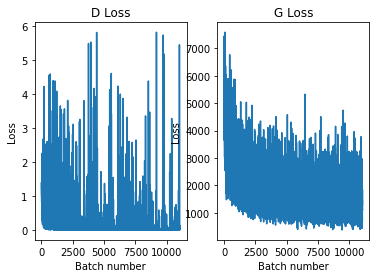

In [ ]:
#Plotting:

#Losses:
plt.subplot(1, 2, 1)
plt.plot(D_losses)
plt.title("D Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(G_losses)
plt.title("G Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss");

In [ ]:
val_moving = validation_set[0:10][0]
val_fixed = validation_set[0:10][1]

if use_gpu:
  val_moving = val_moving.cuda()
  val_fixed = val_fixed.cuda()

val_registered,_ = G(val_moving, val_fixed)

Text(0.5, 1.0, 'Moving Image')

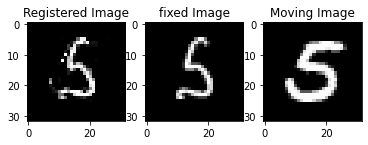

In [ ]:
plt.subplot(1,3,1)
plt.imshow(val_registered[0].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,2)
plt.imshow(val_fixed[0].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("fixed Image")
plt.subplot(1,3,3)
plt.imshow(val_moving[0].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")
